In [1]:
import logging, itertools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
from astropy.io import fits
from astropy.wcs import WCS
from scipy.linalg import cho_solve, cho_factor

logging.basicConfig(level=logging.DEBUG)

In [2]:
filename = "tpf/ktwo202521690-c02_lpd-targ.fits"

In [52]:
hdu = fits.open(filename,mode='readonly',memmap=True)

#Then take a look at instr[0].header (header info) and instr[1].data (pixel values)...

table = hdu[1].data[:]
times = table['TIME']
pixels = table['FLUX']
maskmap = hdu[2].data
maskheader = hdu[2].header

ra = hdu[0].header["RA_OBJ"]
dec = hdu[0].header["DEC_OBJ"]
hdu.close()

In [8]:
hdu.info()

Filename: tpf/ktwo202521690-c02_lpd-targ.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      54   ()              
1    TARGETTABLES  BinTableHDU    274   3856R x 12C   [D, E, J, 210J, 210E, 210E, 210E, 210E, 210E, J, E, E]   
2    APERTURE    ImageHDU        48   (14, 15)     int32   


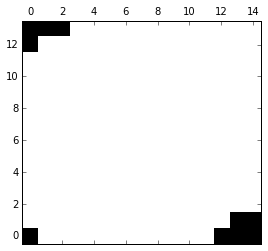

In [34]:
m = plt.matshow(maskmap.T, alpha=1, cmap="cubehelix", origin=(0,0))

In [11]:
num_steps = np.shape(pixels)[0]
print maskmap.shape
print maskmap.shape[0]

(15, 14)
15


In [12]:
def pix_coords():
    cards2 = hdu[2].header.cards
    crpix1 = cards2['CRPIX1'].value
    crpix2 = cards2['CRPIX2'].value
    crval1 = cards2['CRVAL1'].value
    crval2 = cards2['CRVAL2'].value
    cdelt1 = cards2['CDELT1'].value
    cdelt2 = cards2['CDELT2'].value
    print crpix1, crpix2, crval1, crval2, cdelt1, cdelt2
    
    lenRA, lenDec = maskmap.shape
    aperRA = np.zeros(lenRA,"float64")
    aperDec = np.zeros(lenDec,"float64")

    for i in range(lenDec):
        aperDec[i] = crval2 + (i + 1 - crpix2) * cdelt2
        
    for j in range(lenRA):
        aperRA[j] = crval1 + (j + 1 - crpix1) * cdelt1
            
    return aperRA, aperDec

In [13]:
apRA, apDec = pix_coords()

8.47907205964 8.15019240553 243.326865 -29.374343 -0.00110660468398 0.00110660468398


In [14]:
print apRA
print apDec
print ra, dec
pix_RA = np.interp(ra,apRA[::-1],np.arange(len(apRA))[::-1])
pix_Dec = np.interp(dec,apDec,np.arange(len(apDec)))
print pix_RA, pix_Dec

[ 243.33514138  243.33403477  243.33292817  243.33182156  243.33071496
  243.32960835  243.32850175  243.32739514  243.32628854  243.32518193
  243.32407533  243.32296872  243.32186212  243.32075552  243.31964891]
[-29.38225544 -29.38114883 -29.38004223 -29.37893562 -29.37782902
 -29.37672241 -29.37561581 -29.3745092  -29.3734026  -29.37229599
 -29.37118939 -29.37008278 -29.36897618 -29.36786958]
243.326865 -29.374343
7.47907205962 7.15019240553


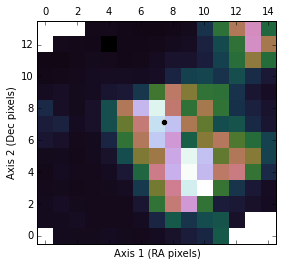

In [16]:
m = plt.matshow(pixels[100].T, alpha=1, cmap="cubehelix", origin=(0,0),norm=colors.LogNorm())
plt.plot(pix_RA, pix_Dec, "ko", mec="w")
plt.xlim(-0.5,maskmap.shape[0]-0.5)
plt.ylim(-0.5,maskmap.shape[1]-0.5)
plt.ylabel("Axis 2 (Dec pixels)")
plt.xlabel("Axis 1 (RA pixels)")

In [17]:
# Below is adapted from code DFM gave me in demo.ipynb
# These are some useful things to pre-compute and use later.
_x, _y = np.meshgrid(range(-1, 2), range(-1, 2), indexing="ij")
_x, _y = _x.flatten(), _y.flatten()
_AT = np.vstack((_x*_x, _y*_y, _x*_y, _x, _y, np.ones_like(_x)))
_ATA = np.dot(_AT, _AT.T)
factor = cho_factor(_ATA, overwrite_a=True)

# This function finds the centroid and second derivatives in a 3x3 patch.
def fit_3x3(img):
    a, b, c, d, e, f = cho_solve(factor, np.dot(_AT, img.flatten()))
    m = 1. / (4 * a * b - c*c)
    x = (c * e - 2 * b * d) * m
    y = (c * d - 2 * a * e) * m
    dx2, dy2, dxdy = 2 * a, 2 * b, c
    return [x, y, dx2, dy2, dxdy]

# This function finds the centroid in an image.
# You can provide an estimate of the centroid using WCS.
def find_centroid(img, init=None):
    if init is None:
        xi, yi = np.unravel_index(np.argmax(img), img.shape)
    else:
        xi, yi = map(int, map(np.round, init))
        ox, oy = np.unravel_index(np.argmax(img[xi-1:xi+2, yi-1:yi+2]), (3, 3))
        xi += ox - 1
        yi += oy - 1
    assert (xi >= 1 and xi < img.shape[0] - 1), "effed, x"
    assert (yi >= 1 and yi < img.shape[1] - 1), "effed, y"
    pos = fit_3x3(img[xi-1:xi+2, yi-1:yi+2])
    pos[0] += xi
    pos[1] += yi
    return pos

def track_centroid(pix_filename):
    # use astropy to get the WCS and estimate the location of the star.
    with fits.open(pixel_filename) as hdus:
        hdr = hdus[2].header
        wcs = WCS(hdr)
        # The order is the opposite of what I normally use...
        init = wcs.wcs_world2pix(hdr["RA_OBJ"], hdr["DEC_OBJ"], 0.0)[::-1]

    # Use the input position to track the centroid across every frame
    coords = np.nan + np.zeros((len(tpf), 5))
    for i, img in enumerate(tpf["FLUX"]):
        msk = np.isfinite(img)
        if np.any(msk) and np.any(img[msk] > 0.0):
            coords[i] = find_centroid(img, init=init)
            
    return coords

In [18]:
wcs = WCS(hdu[2].header)
init = wcs.wcs_world2pix(ra, dec, 0.0)[::-1]
coords = find_centroid(pixels[100], init=init)

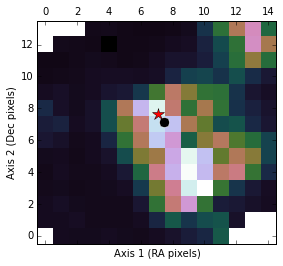

In [19]:
m = plt.matshow(pixels[100].T, alpha=1, cmap="cubehelix", origin=(0,0),norm=colors.LogNorm())
plt.plot(pix_RA, pix_Dec, "ko", mec="w", ms=10)
plt.plot(coords[0],coords[1], "r*", ms=12)
plt.xlim(-0.5,maskmap.shape[0]-0.5)
plt.ylim(-0.5,maskmap.shape[1]-0.5)
plt.ylabel("Axis 2 (Dec pixels)")
plt.xlabel("Axis 1 (RA pixels)")

In [20]:
import photutils

In [21]:
ap_center = [7,7]
print pixels[100][7,7] * (np.pi * 0.5 **2)
apertures = photutils.CircularAperture(ap_center, r=0.5)
photutils.aperture_photometry(pixels[100],apertures)

7183.88973844


aperture_sum,xcenter [1],ycenter [1]
,,
float64,float64,float64
7183.88973844,7.0,7.0


In [22]:
import astropy
astropy.stats.mad_std?

In [43]:
def calc_bkgd(image, mask, ap_center, bkgd_radius, 
              iterations=3, clip_at = 3):
    image_shape = np.shape(image)
    center_dist = np.zeros_like(image)
    for i in range(image_shape[0]):
        for j in range(image_shape[1]):
            sq_sub = [(ap_center[0] - i)**2, 
                      (ap_center[1] - j)**2]
            center_dist[i,j] = np.sqrt(np.sum(sq_sub))
            
    bkgd_mask = np.zeros_like(image)
    bkgd_mask[center_dist>bkgd_radius] = 1
    bkgd_mask[mask==0] = 0
    
    background = image[bkgd_mask==1]
    bkgd_points = background.flatten()
    for i in range(iterations):
#        logging.debug("%d %f",i,len(bkgd_points))
        med, stdev = np.median(bkgd_points), np.std(bkgd_points)
        bad_points = np.where(abs(bkgd_points - med) >= (clip_at * stdev))[0]
        bkgd_points = np.delete(bkgd_points, bad_points)
        
    bkgd_flux = np.median(bkgd_points)
    return bkgd_flux

In [44]:
calc_bkgd(pixels[100], maskmap, ap_center, 3)

353.55209

In [48]:
def get_flux(image, ap_center, ap_radii):
    ap_fluxes = np.zeros(len(ap_radii))
    bkgd_fluxes = np.zeros(len(ap_radii))
    for i, rad in enumerate(ap_radii):
        bkgd_radius = np.ceil(rad + np.sqrt(2))
        bkgd_fluxes[i] = calc_bkgd(image, maskmap, ap_center, bkgd_radius)
        bkgd_subtracted = image - bkgd_fluxes[i]
        
        aperture = photutils.CircularAperture(ap_center, r=rad)
        phot_table = photutils.aperture_photometry(bkgd_subtracted,aperture)
        ap_fluxes[i] = phot_table["aperture_sum"][0]
    return ap_fluxes, bkgd_fluxes

In [49]:
get_flux(pixels[100], ap_center, np.arange(1,6,1))

(array([  22478.846995  ,   55621.47572944,   84104.95552424,
         122733.88723006,  157708.99771712]),
 array([ 353.55209351,  343.49438477,  338.60574341,  338.77346802,
         338.68960571]))

In [57]:
def make_lc(image_list, times, start_center, ap_radii,
            output_filename):
    
    f = open(output_filename,"w")
    f.write("i,t,x,y")
    for r in ap_radii:
        f.write(",flux_{0:.1f},bkgd_{0:.1f}".format(r))
        
    for i, time in enumerate(times):
        f.write("\n{0},{1:.6f}".format(i,time))
        
        coords = find_centroid(image_list[i], init=start_center)
        f.write(",{0:.6f},{1:.6f}".format(coords[0],coords[1]))
        
        ap_fluxes, bkgd_fluxes = get_flux(image_list[i], 
                                          coords[:2], ap_radii)
        
        for i, r in enumerate(ap_radii):
            f.write(",{0:.6f},{1:.6f}".format(ap_fluxes[i],
                                              bkgd_fluxes[i]))
            
    f.close()

In [58]:
wcs = WCS(maskheader)
init = wcs.wcs_world2pix(ra, dec, 0.0)[::-1]
make_lc(pixels, times, init, np.array([2,3,5]),
       "test_lc.csv")

/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: divide by zero encountered in double_scalars
/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars
/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: RuntimeWarning: invalid value encountered in double_scalars
/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater


In [59]:
import astropy.io.ascii as at
data = at.read("test_lc.csv")

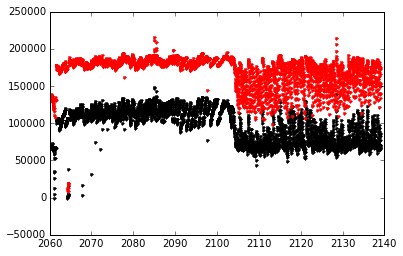

In [65]:
plt.plot(data["t"],data["flux_3.0"],"k.")
plt.plot(data["t"],data["flux_5.0"],"r.")

In [102]:
sources100 = photutils.daofind(pixels[100], fwhm=2.5, threshold = 1e3)
print sources100
sources0 = photutils.daofind(pixels[0], fwhm=2.5, threshold = 1e3)
print sources0

 id   xcentroid     ycentroid   ...      peak          flux          mag      
--- ------------- ------------- ... ------------- ------------- --------------
  1 7.35172125082 7.23239132016 ...     9146.8125 8.94358384719 -2.37877895727
  2  3.9019818012 9.19275561394 ... 15866.9482422 12.7014641998 -2.75963447113
  3 12.3001819225 12.9588449298 ... 4042.70458984 3.82999272956 -1.45799487388
 id   xcentroid     ycentroid   ...      peak          flux          mag      
--- ------------- ------------- ... ------------- ------------- --------------
  1  5.2143501865 5.73619170668 ... 14023.6767578 11.0162702786 -2.60508645643
  2 10.4332542303 11.6044190292 ...   5033.328125 3.43290322674 -1.33915390218


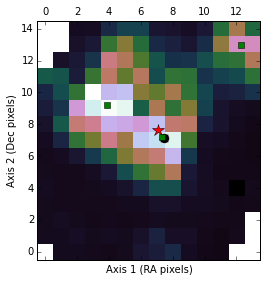

In [103]:
m = plt.matshow(pixels[100], alpha=1, cmap="cubehelix", origin="lower",norm=colors.LogNorm())
plt.plot(pix_RA, pix_Dec, "ko", mec="w", ms=10)
plt.plot(coords[0],coords[1], "r*", ms=12)
plt.xlim(-0.5,maskmap.shape[1]-0.5)
plt.ylim(-0.5,maskmap.shape[0]-0.5)
plt.ylabel("Axis 2 (Dec pixels)")
plt.xlabel("Axis 1 (RA pixels)")
for source in sources100:
    plt.plot(source["xcentroid"], source["ycentroid"], "gs")

In [73]:
ra, dec

(243.326865, -29.374343)

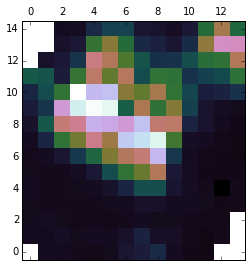

In [91]:
m = plt.matshow(pixels[100], origin="lower", alpha=1, cmap="cubehelix", norm=colors.LogNorm())

In [89]:
plt.imshow?

In [108]:
np.shape(pixels)

(3856, 15, 14)

In [109]:
coadd = np.sum(pixels,axis=0)
np.shape(coadd)

(15, 14)

In [111]:
sources = photutils.daofind(coadd, fwhm=2.5, threshold = 3e4)

/home/stephanie/anaconda/lib/python2.7/site-packages/photutils/detection/findstars.py:161: RuntimeWarning: invalid value encountered in less
  (tbl['roundness2'] < roundhi))


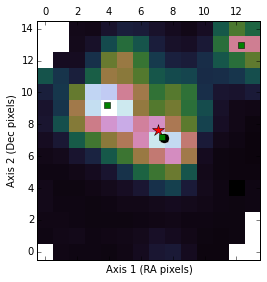

In [112]:
m = plt.matshow(coadd, alpha=1, cmap="cubehelix", origin="lower",norm=colors.LogNorm())
plt.plot(pix_RA, pix_Dec, "ko", mec="w", ms=10)
plt.plot(coords[0],coords[1], "r*", ms=12)
plt.xlim(-0.5,maskmap.shape[1]-0.5)
plt.ylim(-0.5,maskmap.shape[0]-0.5)
plt.ylabel("Axis 2 (Dec pixels)")
plt.xlabel("Axis 1 (RA pixels)")
for source in sources100:
    plt.plot(source["xcentroid"], source["ycentroid"], "gs")